<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/BTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
!pip install --upgrade gdown

!gdown 1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
!gdown 1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
!gdown 1fvMRgqC7ltyQ0Q8PM2fRO9tZ-WJ7pi_E

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
To: /content/images.npy
100% 4.15M/4.15M [00:00<00:00, 249MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
To: /content/tip.npy
100% 1.20k/1.20k [00:00<00:00, 6.15MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fvMRgqC7ltyQ0Q8PM2fRO9tZ-WJ7pi_E
To: /content/surfs.npy
100% 4.15M/4.15M [00:00<00:00, 223MB/s]


In [100]:
!pip install --upgrade gdown

import gdown
gdown.download('https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw', 'images.npy', quiet=False)
gdown.download('https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx', 'tip.npy', quiet=False)
gdown.download('https://drive.google.com/file/d/1fvMRgqC7ltyQ0Q8PM2fRO9tZ-WJ7pi_E/view?usp=sharing', 'surfs.npy', quiet=False)

Downloading...
From: https://drive.google.com/file/d/1fv1ROIuE-1UGbQ6pxsWzSO4CTQwneUnw
To: /content/images.npy
84.2kB [00:00, 2.63MB/s]
Downloading...
From: https://drive.google.com/file/d/1fqkYqCijVlqIIhnxNEmQ2ucDcmf3vOHx
To: /content/tip.npy
84.2kB [00:00, 2.67MB/s]


'tip.npy'

In [2]:
import numpy as np
images = np.load('/content/images.npy')
tip = np.load('/content/tip.npy')
surfaces = np.load('/content/surfs.npy')

surface = surfaces[1, :, :]
image = images[1, :, :]

# Define functions

In [3]:
import torch


def compute_xc_yc(tip):
    tip_xsiz, tip_ysiz = tip.size()
    xc = round(tip_xsiz / 2)
    yc = round(tip_ysiz / 2)
    return xc, yc


def idilation(surface, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    surface = surface.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    surf_xsiz, surf_ysiz = surface.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(surface, -float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the dilation operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(surface, shifts=(-px, -py), dims=(0, 1))
            temp = temp + tip[xc + px, yc + py]
            r = torch.maximum(r, temp)

    return r


def ierosion(image, tip):
    # Move tensors to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    tip = tip.to(device)

    xc, yc = compute_xc_yc(tip)
    im_xsiz, im_ysiz = image.size()
    tip_xsiz, tip_ysiz = tip.size()

    # Initialize result tensor on GPU
    r = torch.full_like(image, float('inf'))

    # Replace nested loops with PyTorch operations
    # Note: The following is a simplified version. Depending on the specific requirements of the erosion operation,
    # you may need to adjust the logic to achieve the correct result.
    for px in range(-xc, tip_xsiz - xc):
        for py in range(-yc, tip_ysiz - yc):
            temp = torch.roll(image, shifts=(px, py), dims=(0, 1))
            temp = temp - tip[xc + px, yc + py]
            r = torch.minimum(r, temp)

    return r


def translate_tip_mean(P, cutoff=10**(-8)):
    # Ensure P is on GPU
    P = P.to('cuda' if torch.cuda.is_available() else 'cpu')

    tip_xsiz, tip_ysiz = P.size()
    xc, yc = compute_xc_yc(P)

    #p_max = torch.min(P)
    #P = P - p_max

    p_min = torch.min(P)
    weight = P - p_min
    weight = weight

    id = weight < cutoff
    weight[id] = 0.0

    if torch.all(weight < 10**(-10)):
        #print('called')
        weight.fill_(1.0)

    ix = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    iy = torch.ones(tip_xsiz, tip_ysiz, dtype=P.dtype, device=P.device)
    ix = torch.cumsum(ix, dim=0) - 1.0
    iy = torch.cumsum(iy, dim=1) - 1.0
    com_x = torch.sum(ix * weight / torch.sum(weight))
    com_y = torch.sum(iy * weight / torch.sum(weight))
    id_x = round(com_x.item())
    id_y = round(com_y.item())

    pxmin = max(- xc, - id_x)
    pymin = max(- yc, - id_y)
    pxmax = min(tip_xsiz - xc, tip_xsiz - id_x)
    pymax = min(tip_ysiz - yc, tip_ysiz - id_y)

    #print(id_x, id_y)
    P_new = torch.full_like(P, p_min.item())
    P_new[(xc + pxmin):(xc + pxmax), (yc + pymin):(yc + pymax)] = P[(id_x + pxmin):(id_x + pxmax), (id_y + pymin):(id_y + pymax)]

    return P_new


# Check dilation

In [5]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 300

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image2_tensor = idilation(surface_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((image2_tensor - image_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 6.232139587402344
Iteration 100, Loss: 0.10994898527860641
Iteration 200, Loss: 0.08266109228134155


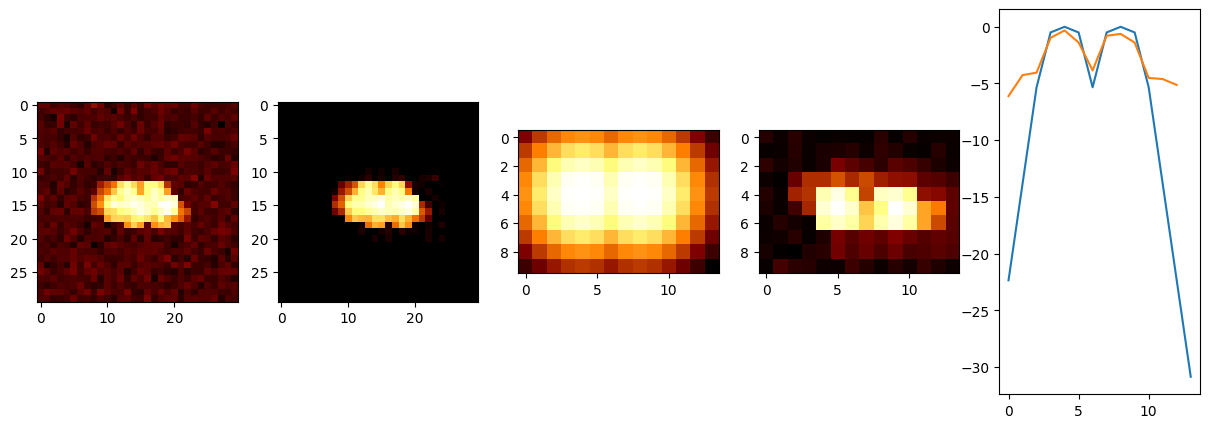

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[4, 1:])

# Check erosion

In [12]:
import torch
import torch.optim as optim
import numpy as np

# Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surface_tensor = torch.tensor(surface, dtype=torch.float32)
image_tensor = torch.tensor(image, dtype=torch.float32)
surface_tensor = surface_tensor.to(device)
image_tensor = image_tensor.to(device)

# Initialization
tip_tensor = torch.zeros(tip.shape, dtype=torch.float32, requires_grad=True)

# Optimization settings
learning_rate = 0.1
optimizer = optim.Adam([tip_tensor], lr=learning_rate)
num_iterations = 300

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    surface2_tensor = ierosion(image_tensor, tip_tensor)

    # Calculate MSE loss
    loss = torch.mean((surface2_tensor - surface_tensor) ** 2)

    # Backpropagation
    loss.backward()

    # Update tip
    optimizer.step()

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().numpy()


Iteration 0, Loss: 1.2834912538528442
Iteration 100, Loss: 0.14977437257766724
Iteration 200, Loss: 0.08417634665966034


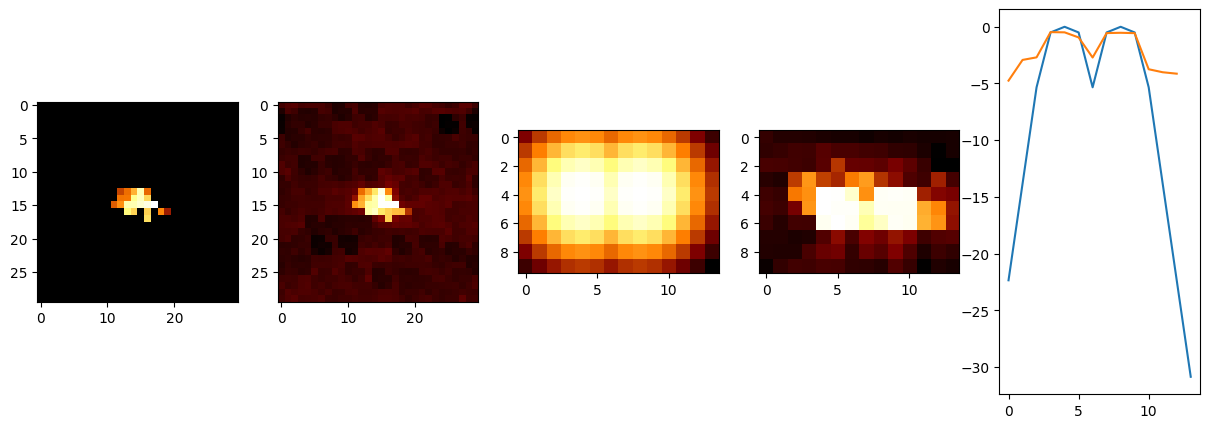

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(surface_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(ierosion(image_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[4, 1:])

# Check opening

In [25]:
import torch
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(images[0, :, :], dtype=torch.float32)
image_tensor = image_tensor.to(device)

# Initialize tip with random values
tip_size = tip.shape
tip_tensor = torch.zeros(tip_size, dtype=torch.float64, requires_grad=True, device=device)

# Optimization settings
optimizer = optim.Adam([tip_tensor], lr=1.0)
num_iterations = 1000

# Optimization loop
for iteration in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Perform dilation
    image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
    #print(torch.max(image_reconstructed))

    # Calculate MSE loss
    loss = torch.mean((image_reconstructed - image_tensor)**2)

    # Backpropagation
    loss.backward()
    #print(tip_tensor.grad)

    # Update tip
    optimizer.step()

    with torch.no_grad():
        tip_tensor.data = torch.clamp(tip_tensor, max=0.0)
        tip_tensor.data = translate_tip_mean(tip_tensor)

    # Optional: print loss every few iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}")

# Final optimized tip
tip_estimate = tip_tensor.detach().to('cpu').numpy()

Iteration 0, Loss: 6.582793712615967
Iteration 100, Loss: 0.7860257029533386
Iteration 200, Loss: 0.3028326630592346
Iteration 300, Loss: 0.15350589156150818
Iteration 400, Loss: 0.22983598709106445
Iteration 500, Loss: 0.1459663063287735
Iteration 600, Loss: 0.17477983236312866
Iteration 700, Loss: 0.2018461674451828
Iteration 800, Loss: 0.24441978335380554
Iteration 900, Loss: 0.2253282517194748


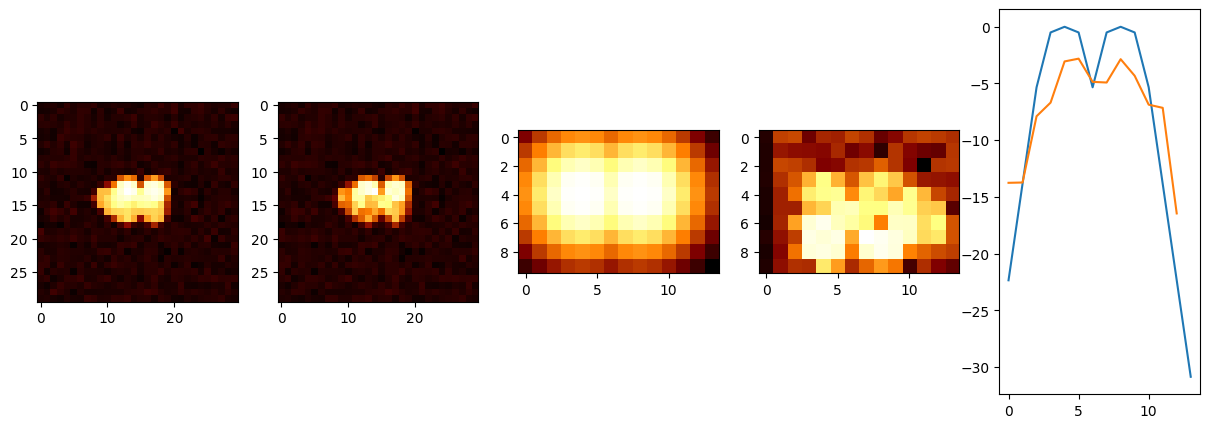

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
import matplotlib.pyplot as plt
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(1, 5, 2)
plt.imshow(idilation(ierosion(image_tensor, tip_tensor), tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(1, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(1, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(1, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[5, 1:])

# DataLoader

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import copy

lambda_my = 0.00001
lr_my = 1.0
nepoch = 20

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = torch.tensor(images[0, :, :], dtype=torch.float32)
image_tensor = image_tensor.to(device)

# Initialize tip with random values
tip_size = tip.shape
tip_tensor = torch.zeros(tip_size, dtype=torch.float64, requires_grad=True, device=device)

# Optimization settings
optimizer = optim.AdamW([tip_tensor], lr=lr_my, weight_decay=lambda_my)

loss_train = []
for epoch in range(nepoch):
    loss_tmp = 0.0
    for x in data_loader:
        optimizer.zero_grad()
        image_reconstructed = idilation(ierosion(x[0, :, :], tip_tensor), tip_tensor)
        loss = torch.mean((image_reconstructed - x[0, :, :])**2)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            tip_tensor.data = torch.clamp(tip_tensor, max=0.0)
            tip_tensor.data = translate_tip_mean(tip_tensor)
        image_reconstructed = idilation(ierosion(x[0, :, :], tip_tensor), tip_tensor)
        loss = torch.mean((image_reconstructed - x[0, :, :])**2)
        loss_tmp += loss.item()
    if iteration % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss_tmp}")
    loss_train.append(loss_tmp)

tip_estimate = tip_tensor.detach().to('cpu').numpy()

Epoch: 0, Loss: 102.72906053066254
Epoch: 1, Loss: 46.47594428062439
Epoch: 2, Loss: 24.11820548772812
Epoch: 3, Loss: 17.164126336574554
Epoch: 4, Loss: 10.673492670059204
Epoch: 5, Loss: 7.033156655728817
Epoch: 6, Loss: 4.352022096514702
Epoch: 7, Loss: 3.439511016011238
Epoch: 8, Loss: 2.5697925183922052
Epoch: 9, Loss: 2.0138334445655346
Epoch: 10, Loss: 1.870833020657301
Epoch: 11, Loss: 2.0195853039622307
Epoch: 12, Loss: 1.8604997098445892
Epoch: 13, Loss: 1.6788408104330301
Epoch: 14, Loss: 1.9141072183847427
Epoch: 15, Loss: 1.9883024245500565
Epoch: 16, Loss: 1.8102708645164967
Epoch: 17, Loss: 2.2903480380773544
Epoch: 18, Loss: 2.191157530993223
Epoch: 19, Loss: 2.1514751091599464


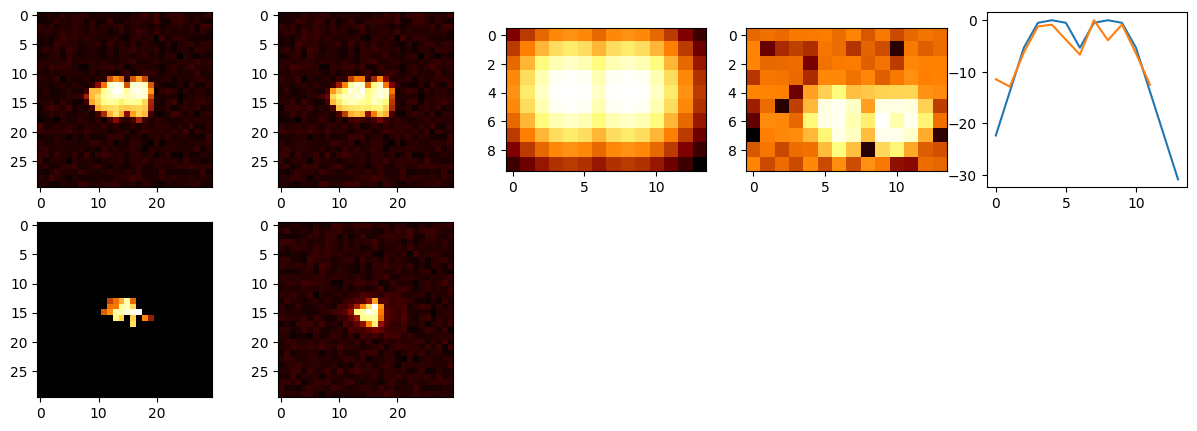

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(2, 5, 1)
plt.imshow(image_tensor.cpu(), cmap='afmhot')

plt.subplot(2, 5, 2)
plt.imshow(idilation(ierosion(image_tensor, tip_tensor), tip_tensor).cpu().detach().numpy(), cmap='afmhot')

plt.subplot(2, 5, 3)
plt.imshow(tip, cmap='afmhot')

plt.subplot(2, 5, 4)
plt.imshow(tip_estimate, cmap='afmhot')

plt.subplot(2, 5, 5)
plt.plot(tip[4, :])
plt.plot(tip_estimate[6, 2:])

plt.subplot(2, 5, 6)
plt.imshow(surface_tensor.cpu(), cmap='afmhot')

plt.subplot(2, 5, 7)
plt.imshow(ierosion(image_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

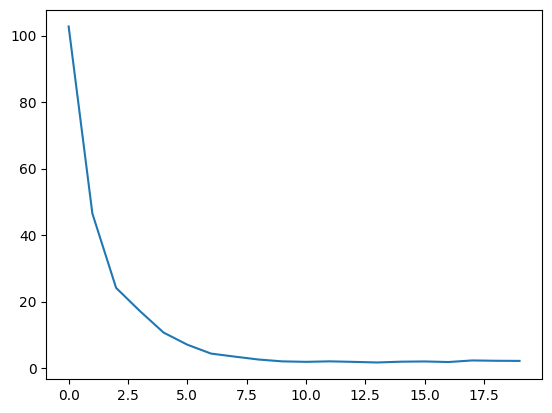

In [55]:
plt.plot(loss_train)

# Working in progress...

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim import AdamW
import copy

lambda_my = 0.00001
lr_my = 1.0
nepoch = 10

class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, :, :]
        image = torch.from_numpy(image).float()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        return image

# Datasetオブジェクトを作成
image_dataset = ImageDataset(images[:30, :, :])

# DataLoaderを作成
data_loader = DataLoader(image_dataset, batch_size=1, shuffle=False)

# CustomModelを作成
class CustomModel(torch.nn.Module):
    def __init__(self, tip):
        super(CustomModel, self).__init__()
        nx, ny = tip.shape
        initial_tip = torch.zeros((nx, ny), dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        initial_tip = initial_tip.to(device)
        self.P = torch.nn.Parameter(initial_tip)

    def forward(self, x):
        return idilation(ierosion(x, self.P), self.P)

m = CustomModel(tip)

def loss_fn(image):
    return torch.nn.functional.mse_loss(m.forward(image), image, reduction='mean')

optimizer = AdamW(m.parameters(), lr=lr_my, weight_decay=lambda_my)

In [255]:
loss_train = []
for epoch in range(nepoch):
    loss_tmp = 0.0
    for x in data_loader:
        optimizer.zero_grad()
        loss = loss_fn(x[0])
        loss.backward()
        optimizer.step()
        #with torch.no_grad():
            #m.P.data = torch.clamp(m.P, max=0.0)
            #m.P.data = translate_tip_mean(m.P)
        loss_tmp += loss_fn(x[0]).item()

    print(epoch, loss_tmp)
    loss_train.append(loss_tmp)

tip_estimate = m.P.detach().to('cpu').numpy()

0 95.3866126537323
1 95.3866126537323
2 95.3866126537323
3 95.3866126537323
4 95.3866126537323
5 95.3866126537323
6 95.3866126537323
7 95.3866126537323
8 95.3866126537323
9 95.3866126537323


tensor(12.1353, device='cuda:0', grad_fn=<MaxBackward1>)


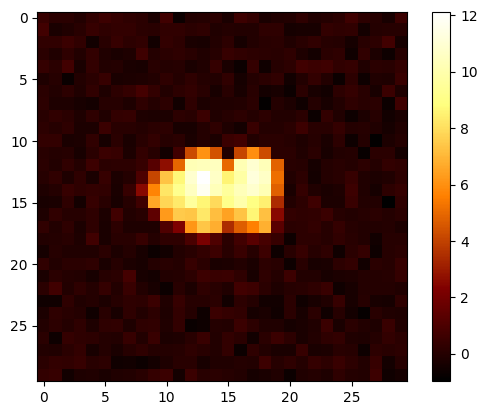

In [461]:
image_reconstructed = idilation(ierosion(image_tensor, tip_tensor), tip_tensor)
plt.imshow(image_reconstructed.detach().cpu(), cmap='afmhot')
plt.colorbar()
print(torch.max(image_reconstructed))

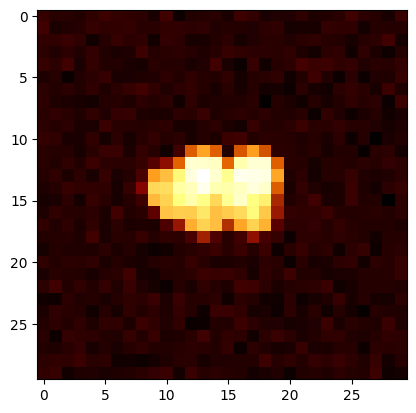

In [462]:
plt.imshow(image_tensor.cpu(), cmap='afmhot')

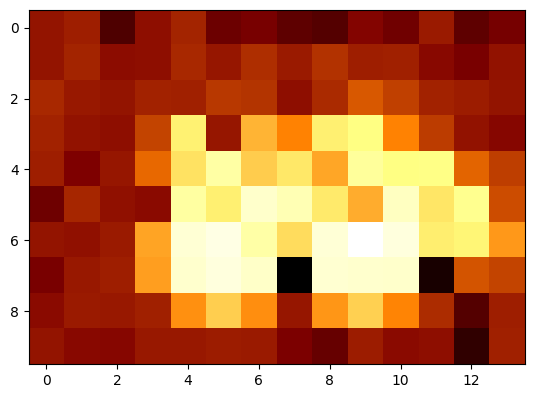

In [463]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip_estimate, cmap='afmhot')

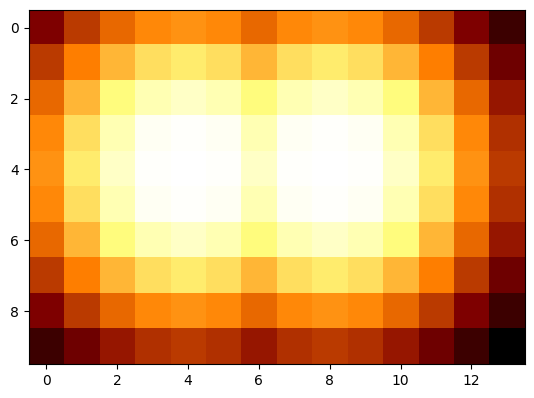

In [464]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(tip, cmap='afmhot')

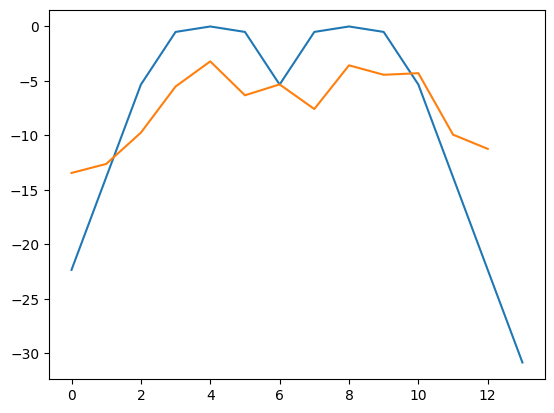

In [465]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.plot(tip[4, :])
plt.plot(tip_estimate[4, 1:])